This code runs FedDR on MNIST dataset, This code is developed on FedPD code to incorporate FedADMM changes(https://github.com/564612540/FedPD), The logic for the FedDR code is taken from https://github.com/unc-optimization/FedDR/tree/main/FedDR, The synthetic dataset used is created based on the code from 
https://github.com/litian96/FedProx/tree/master/data

In [1]:
from google.colab import drive

# The following command will prompt a URL for you to click and obtain the
# authorization code

drive.mount("/content/drive")

Mounted at /content/drive


In [2]:
from pathlib import Path

# Change this to where you put your hw1 files
DATA = Path("/content/drive/MyDrive/Fed_unchanged/FedPD/Python")

In [3]:
import os
import copy
import time
import pickle
import json
import numpy as np
from tqdm import tqdm

import torch
from torch import nn

torch.manual_seed(0)

In [4]:
os.chdir(DATA / 'src')
from options import args_parser
from update import LocalUpdate, test_inference
from models import MLP, CNNMnist, CNNFashion_Mnist, CNNCifar, CNNFEMnist
from utils import get_dataset, average_weights, exp_details
from agent import Agent

In [5]:
class arg:
  def __init__(self):
    self.epochs = 200 #number of global rounds
    self.freq_in = 300 #number of inner loops
    self.freq_out = 1 
    self.num_users = 30 # Total number of users
    self.partial_users = 10 # number of partial users
    self.local_ep = 300
    self.local_bs = 2
    self.lr = 0.01
    self.mu = 1
    #self.dataset = 'femnist'
    self.VR = False
    self.model = 'mlp' 
    self.optimizer = 'FedDR' 
    self.gpu = False
args = arg()

In [6]:
os.chdir('..')

In [7]:
#choose which synthetic dataset to run
train_path = os.path.join('data', 'synthetic_1_1', 'data', 'train')
test_path = os.path.join('data', 'synthetic_1_1', 'data', 'test')

In [8]:
clients = []
groups = []
train_data = {}
test_data = {}

train_files = os.listdir(train_path)
train_files = [f for f in train_files if f.endswith('.json')]
for f in train_files:
    file_path = os.path.join(train_path,f)
    with open(file_path, 'r') as inf:
        cdata = json.load(inf)
    clients.extend(cdata['users'])
    if 'hierarchies' in cdata:
        groups.extend(cdata['hierarchies'])
    train_data.update(cdata['user_data'])

test_files = os.listdir(test_path)
test_files = [f for f in test_files if f.endswith('.json')]
for f in test_files:
    file_path = os.path.join(test_path,f)
    with open(file_path, 'r') as inf:
        cdata = json.load(inf)
    test_data.update(cdata['user_data'])

clients = list(sorted(train_data.keys()))

In [9]:
user_groups = {i:len(train_data[key]['x']) for i,key in enumerate(train_data.keys())}
temp = 0
for i in user_groups.keys():
  user_groups[i] = np.arange(temp,user_groups[i]+temp)
  temp += len(user_groups[i])

In [10]:
import torch
from torch.utils.data import DataLoader, Dataset
class DatasetSplit(Dataset):
    """An abstract Dataset class wrapped around Pytorch Dataset class.
    """

    def __init__(self, dataset, idxs):
        self.dataset = dataset
        self.idxs = [int(i) for i in idxs]

    def __len__(self):
        return len(self.idxs)

    def __getitem__(self, item):
        image, label = self.dataset[self.idxs[item]]
        return torch.tensor(image,dtype=torch.float32), torch.tensor(label)

In [11]:
dict_users = {i: np.array([]) for i in range(30)} # number of users
train_size = 0
test_size = 0
train_data_new = []
test_data_new = []

for user in clients:
    train_data_new.extend([[np.array(x,dtype=np.float),np.array(y,dtype=np.int64)] for x,y in zip(train_data[user]['x'],train_data[user]['y'])])
    test_data_new.extend([[np.array(x,dtype=np.float),np.array(y,dtype=np.int64)] for x,y in zip(test_data[user]['x'],test_data[user]['y'])])

idxs_train = np.arange(sum(len(train_data[key]['x']) for i,key in enumerate(train_data.keys())))
train_data = DatasetSplit(train_data_new, idxs_train)
idxs_test = np.arange(sum(len(test_data[key]['x']) for i,key in enumerate(test_data.keys())))
test_data = DatasetSplit(test_data_new, idxs_test)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if __name__ == '__main__':


In [18]:
user_groups

{0: array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45]),
 1: array([ 46,  47,  48,  49,  50,  51,  52,  53,  54,  55,  56,  57,  58,
         59,  60,  61,  62,  63,  64,  65,  66,  67,  68,  69,  70,  71,
         72,  73,  74,  75,  76,  77,  78,  79,  80,  81,  82,  83,  84,
         85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  96,  97,
         98,  99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110,
        111, 112, 113, 114, 115, 116, 117, 118, 119, 120]),
 2: array([121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133,
        134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146,
        147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159,
        160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172]),
 3: array([173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 1

In [12]:
global_model = MLP(60,32,10)
global_model.train()

MLP(
  (layer_input): Linear(in_features=60, out_features=32, bias=True)
  (relu): ReLU()
  (layer_hidden1): Linear(in_features=32, out_features=32, bias=True)
  (layer_hidden): Linear(in_features=32, out_features=10, bias=True)
  (softmax): Softmax(dim=1)
)

In [13]:
if args.gpu:
        torch.cuda.set_device(args.gpu)
device = 'cuda' if args.gpu else 'cpu'

In [14]:
agent_list = []
for i in range(args.num_users):
    agent_list.append(Agent(global_model,args,i, nn.NLLLoss().to(device)))

# copy weights
global_weights = global_model.state_dict()

In [15]:
train_loss, train_accuracy = [], []
val_acc_list, net_list = [], []
cv_loss, cv_acc = [], []
print_every = 5
val_loss_pre, counter = 0, 0

In [ ]:
import random
random.seed(10)
global_dict = {}
for epoch in tqdm(range(args.epochs)):
  local_weights = []
  print(f'\n | Global Training Round : {epoch+1} |\n')

  m = args.num_users
  if epoch % args.freq_out ==0:
      compute_full = True
      update_model = True
  else:
      compute_full = False
      update_model = False
  global_model.train()
#keep a copy of all the local state dictionaries globally
  if epoch == 0:
    for idx in range(args.num_users):
      global_dict[str(idx)] = global_model.state_dict()
# randomly choose which users to use for global update
  S = [str(i) for i in random.sample(range(args.num_users),args.partial_users)]
# run the clients that are selected
  for idx in S:
      w= agent_list[int(idx)].train_(global_model.state_dict(), args.freq_in, train_data, user_groups, update_model, compute_full)
      # print(w['layer3.0.bias'])
      local_weights.append(copy.deepcopy(w))
      global_dict[idx] = local_weights[-1]
  # for idx in range(args.num_users):
  #     print(local_weights[idx]['layer3.0.bias'])


  if S:
      w_avg = copy.deepcopy(local_weights[0])
      w_avg = {key: w_avg[key]-w_avg[key] for key in w_avg.keys()}
      for key in w_avg.keys():
          for i in range(args.num_users):
              w_avg[key].add_(global_dict[str(i)][key])
          w_avg[key].div_(args.num_users)
  # print(w_avg['layer3.0.bias'])

  # update global weights
      global_weights = w_avg

  # update global weights
      global_model.load_state_dict(global_weights)
  # print(global_model)

  # Calculate avg training accuracy over all users at every epoch
  global_model.eval()
  test_acc, test_loss = test_inference(args, global_model, test_data)
  train_accuracy.append(test_acc)
  train_loss.append(test_loss)

  # print global training loss after every 'i' rounds
  if (epoch+1) % print_every == 0:
      print(f' \nAvg Training Stats after {epoch+1} global rounds:')
      print(f'Training Loss : {np.mean(np.array(train_loss))}')
      print('Train Accuracy: {:.2f}% \n'.format(100*train_accuracy[-1]),flush=True)

  0%|          | 0/200 [00:00<?, ?it/s]


 | Global Training Round : 1 |



/content/drive/MyDrive/Fed_unchanged/FedPD/Python/src/agent.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(image,dtype=torch.float32), torch.tensor(label)
/content/drive/MyDrive/Fed_unchanged/FedPD/Python/src/optimizer.py:253: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at  ../torch/csrc/utils/python_arg_parser.cpp:1050.)
  p.data.add_(-group['lr'], d_p+(p.data - lamb)*mu)
  0%|          | 1/200 [00:02<08:34,  2.58s/it]


 | Global Training Round : 2 |



  1%|          | 2/200 [00:04<06:58,  2.11s/it]


 | Global Training Round : 3 |



  2%|▏         | 3/200 [00:06<06:22,  1.94s/it]


 | Global Training Round : 4 |



  2%|▏         | 4/200 [00:07<06:06,  1.87s/it]


 | Global Training Round : 5 |

 
Avg Training Stats after 5 global rounds:
Training Loss : 14.021923208236695
Train Accuracy: 44.37% 



  2%|▎         | 5/200 [00:09<05:58,  1.84s/it]


 | Global Training Round : 6 |



  3%|▎         | 6/200 [00:11<05:50,  1.81s/it]


 | Global Training Round : 7 |



  4%|▎         | 7/200 [00:13<05:43,  1.78s/it]


 | Global Training Round : 8 |



  4%|▍         | 8/200 [00:14<05:38,  1.77s/it]


 | Global Training Round : 9 |



  4%|▍         | 9/200 [00:16<05:33,  1.75s/it]


 | Global Training Round : 10 |

 
Avg Training Stats after 10 global rounds:
Training Loss : 12.705644732713699
Train Accuracy: 42.44% 



  5%|▌         | 10/200 [00:18<05:31,  1.74s/it]


 | Global Training Round : 11 |



  6%|▌         | 11/200 [00:20<05:30,  1.75s/it]


 | Global Training Round : 12 |



  6%|▌         | 12/200 [00:21<05:27,  1.74s/it]


 | Global Training Round : 13 |



  6%|▋         | 13/200 [00:23<05:27,  1.75s/it]


 | Global Training Round : 14 |



  7%|▋         | 14/200 [00:25<05:25,  1.75s/it]


 | Global Training Round : 15 |

 
Avg Training Stats after 15 global rounds:
Training Loss : 11.951570177078247
Train Accuracy: 44.93% 



  8%|▊         | 15/200 [00:27<05:23,  1.75s/it]


 | Global Training Round : 16 |



  8%|▊         | 16/200 [00:28<05:21,  1.75s/it]


 | Global Training Round : 17 |



  8%|▊         | 17/200 [00:30<05:20,  1.75s/it]


 | Global Training Round : 18 |



  9%|▉         | 18/200 [00:32<05:16,  1.74s/it]


 | Global Training Round : 19 |



 10%|▉         | 19/200 [00:34<05:14,  1.74s/it]


 | Global Training Round : 20 |

 
Avg Training Stats after 20 global rounds:
Training Loss : 11.42711953818798
Train Accuracy: 55.72% 



 10%|█         | 20/200 [00:35<05:13,  1.74s/it]


 | Global Training Round : 21 |



 10%|█         | 21/200 [00:37<05:10,  1.74s/it]


 | Global Training Round : 22 |



 11%|█         | 22/200 [00:39<05:08,  1.74s/it]


 | Global Training Round : 23 |



 12%|█▏        | 23/200 [00:40<05:07,  1.73s/it]


 | Global Training Round : 24 |



 12%|█▏        | 24/200 [00:42<05:04,  1.73s/it]


 | Global Training Round : 25 |

 
Avg Training Stats after 25 global rounds:
Training Loss : 11.031371533870697
Train Accuracy: 47.05% 



 12%|█▎        | 25/200 [00:44<05:03,  1.73s/it]


 | Global Training Round : 26 |



 13%|█▎        | 26/200 [00:46<05:02,  1.74s/it]


 | Global Training Round : 27 |



 14%|█▎        | 27/200 [00:47<05:00,  1.74s/it]


 | Global Training Round : 28 |



 14%|█▍        | 28/200 [00:50<05:32,  1.93s/it]


 | Global Training Round : 29 |



 14%|█▍        | 29/200 [00:52<05:19,  1.87s/it]


 | Global Training Round : 30 |

 
Avg Training Stats after 30 global rounds:
Training Loss : 10.72071345448494
Train Accuracy: 55.26% 



 15%|█▌        | 30/200 [00:53<05:11,  1.83s/it]


 | Global Training Round : 31 |



 16%|█▌        | 31/200 [00:55<05:04,  1.80s/it]


 | Global Training Round : 32 |



 16%|█▌        | 32/200 [00:57<05:01,  1.79s/it]


 | Global Training Round : 33 |



 16%|█▋        | 33/200 [00:58<04:57,  1.78s/it]


 | Global Training Round : 34 |



 17%|█▋        | 34/200 [01:00<04:52,  1.76s/it]


 | Global Training Round : 35 |

 
Avg Training Stats after 35 global rounds:
Training Loss : 10.468699942316327
Train Accuracy: 47.60% 



 18%|█▊        | 35/200 [01:02<04:49,  1.76s/it]


 | Global Training Round : 36 |



 18%|█▊        | 36/200 [01:04<04:49,  1.76s/it]


 | Global Training Round : 37 |



 18%|█▊        | 37/200 [01:05<04:46,  1.76s/it]


 | Global Training Round : 38 |



 19%|█▉        | 38/200 [01:07<04:44,  1.75s/it]


 | Global Training Round : 39 |



 20%|█▉        | 39/200 [01:09<04:42,  1.75s/it]


 | Global Training Round : 40 |

 
Avg Training Stats after 40 global rounds:
Training Loss : 10.259787778556348
Train Accuracy: 57.66% 



 20%|██        | 40/200 [01:11<04:40,  1.76s/it]


 | Global Training Round : 41 |



 20%|██        | 41/200 [01:12<04:37,  1.75s/it]


 | Global Training Round : 42 |



 21%|██        | 42/200 [01:14<04:36,  1.75s/it]


 | Global Training Round : 43 |



 22%|██▏       | 43/200 [01:16<04:33,  1.74s/it]


 | Global Training Round : 44 |



 22%|██▏       | 44/200 [01:18<04:31,  1.74s/it]


 | Global Training Round : 45 |

 
Avg Training Stats after 45 global rounds:
Training Loss : 10.076976448959774
Train Accuracy: 58.95% 



 22%|██▎       | 45/200 [01:19<04:30,  1.75s/it]


 | Global Training Round : 46 |



 23%|██▎       | 46/200 [01:21<04:29,  1.75s/it]


 | Global Training Round : 47 |



 24%|██▎       | 47/200 [01:23<04:27,  1.75s/it]


 | Global Training Round : 48 |



 24%|██▍       | 48/200 [01:25<04:25,  1.74s/it]


 | Global Training Round : 49 |



 24%|██▍       | 49/200 [01:26<04:24,  1.75s/it]


 | Global Training Round : 50 |

 
Avg Training Stats after 50 global rounds:
Training Loss : 9.917255665063857
Train Accuracy: 57.84% 



 25%|██▌       | 50/200 [01:28<04:23,  1.76s/it]


 | Global Training Round : 51 |



 26%|██▌       | 51/200 [01:30<04:21,  1.76s/it]


 | Global Training Round : 52 |



 26%|██▌       | 52/200 [01:32<04:20,  1.76s/it]


 | Global Training Round : 53 |



 26%|██▋       | 53/200 [01:34<04:19,  1.77s/it]


 | Global Training Round : 54 |



 27%|██▋       | 54/200 [01:35<04:18,  1.77s/it]


 | Global Training Round : 55 |

 
Avg Training Stats after 55 global rounds:
Training Loss : 9.775144201517104
Train Accuracy: 54.70% 



 28%|██▊       | 55/200 [01:37<04:15,  1.76s/it]


 | Global Training Round : 56 |



 28%|██▊       | 56/200 [01:39<04:13,  1.76s/it]


 | Global Training Round : 57 |



 28%|██▊       | 57/200 [01:41<04:12,  1.77s/it]


 | Global Training Round : 58 |



 29%|██▉       | 58/200 [01:42<04:10,  1.76s/it]


 | Global Training Round : 59 |



 30%|██▉       | 59/200 [01:44<04:07,  1.76s/it]


 | Global Training Round : 60 |

 
Avg Training Stats after 60 global rounds:
Training Loss : 9.645621335009734
Train Accuracy: 56.64% 



 30%|███       | 60/200 [01:46<04:04,  1.75s/it]


 | Global Training Round : 61 |



 30%|███       | 61/200 [01:48<04:03,  1.75s/it]


 | Global Training Round : 62 |



 31%|███       | 62/200 [01:49<04:02,  1.76s/it]


 | Global Training Round : 63 |



 32%|███▏      | 63/200 [01:51<04:00,  1.76s/it]


 | Global Training Round : 64 |



 32%|███▏      | 64/200 [01:53<03:58,  1.75s/it]


 | Global Training Round : 65 |

 
Avg Training Stats after 65 global rounds:
Training Loss : 9.519776175572321
Train Accuracy: 56.27% 



 32%|███▎      | 65/200 [01:55<03:56,  1.75s/it]


 | Global Training Round : 66 |



 33%|███▎      | 66/200 [01:56<03:54,  1.75s/it]


 | Global Training Round : 67 |



 34%|███▎      | 67/200 [01:58<03:52,  1.75s/it]


 | Global Training Round : 68 |



 34%|███▍      | 68/200 [02:00<03:50,  1.75s/it]


 | Global Training Round : 69 |



 34%|███▍      | 69/200 [02:02<03:48,  1.75s/it]


 | Global Training Round : 70 |

 
Avg Training Stats after 70 global rounds:
Training Loss : 9.415166478923389
Train Accuracy: 52.77% 



 35%|███▌      | 70/200 [02:03<03:48,  1.75s/it]


 | Global Training Round : 71 |



 36%|███▌      | 71/200 [02:05<03:46,  1.75s/it]


 | Global Training Round : 72 |



 36%|███▌      | 72/200 [02:07<03:44,  1.76s/it]


 | Global Training Round : 73 |



 36%|███▋      | 73/200 [02:09<03:42,  1.75s/it]


 | Global Training Round : 74 |



 37%|███▋      | 74/200 [02:10<03:41,  1.75s/it]


 | Global Training Round : 75 |

 
Avg Training Stats after 75 global rounds:
Training Loss : 9.308276445070902
Train Accuracy: 60.06% 



 38%|███▊      | 75/200 [02:12<03:38,  1.75s/it]


 | Global Training Round : 76 |



 38%|███▊      | 76/200 [02:14<03:36,  1.74s/it]


 | Global Training Round : 77 |



 38%|███▊      | 77/200 [02:16<03:34,  1.74s/it]


 | Global Training Round : 78 |



 39%|███▉      | 78/200 [02:17<03:32,  1.74s/it]


 | Global Training Round : 79 |



 40%|███▉      | 79/200 [02:19<03:31,  1.75s/it]


 | Global Training Round : 80 |

 
Avg Training Stats after 80 global rounds:
Training Loss : 9.203875397890807
Train Accuracy: 64.02% 



 40%|████      | 80/200 [02:21<03:29,  1.74s/it]


 | Global Training Round : 81 |



 40%|████      | 81/200 [02:23<03:27,  1.75s/it]


 | Global Training Round : 82 |



 41%|████      | 82/200 [02:24<03:25,  1.74s/it]


 | Global Training Round : 83 |



 42%|████▏     | 83/200 [02:26<03:24,  1.74s/it]


 | Global Training Round : 84 |



 42%|████▏     | 84/200 [02:28<03:22,  1.75s/it]


 | Global Training Round : 85 |

 
Avg Training Stats after 85 global rounds:
Training Loss : 9.105784531200634
Train Accuracy: 64.21% 



 42%|████▎     | 85/200 [02:30<03:21,  1.75s/it]


 | Global Training Round : 86 |



 43%|████▎     | 86/200 [02:31<03:20,  1.76s/it]


 | Global Training Round : 87 |



 44%|████▎     | 87/200 [02:33<03:19,  1.76s/it]


 | Global Training Round : 88 |



 44%|████▍     | 88/200 [02:35<03:16,  1.76s/it]


 | Global Training Round : 89 |



 44%|████▍     | 89/200 [02:37<03:13,  1.75s/it]


 | Global Training Round : 90 |

 
Avg Training Stats after 90 global rounds:
Training Loss : 9.011824210484823
Train Accuracy: 63.47% 



 45%|████▌     | 90/200 [02:38<03:12,  1.75s/it]


 | Global Training Round : 91 |



 46%|████▌     | 91/200 [02:40<03:10,  1.75s/it]


 | Global Training Round : 92 |



 46%|████▌     | 92/200 [02:42<03:09,  1.76s/it]


 | Global Training Round : 93 |



 46%|████▋     | 93/200 [02:44<03:08,  1.77s/it]


 | Global Training Round : 94 |



 47%|████▋     | 94/200 [02:45<03:07,  1.77s/it]


 | Global Training Round : 95 |

 
Avg Training Stats after 95 global rounds:
Training Loss : 8.922332888214212
Train Accuracy: 64.30% 



 48%|████▊     | 95/200 [02:47<03:05,  1.77s/it]


 | Global Training Round : 96 |



 48%|████▊     | 96/200 [02:49<03:04,  1.78s/it]


 | Global Training Round : 97 |



 48%|████▊     | 97/200 [02:51<03:02,  1.77s/it]


 | Global Training Round : 98 |



 49%|████▉     | 98/200 [02:53<03:00,  1.77s/it]


 | Global Training Round : 99 |



 50%|████▉     | 99/200 [02:54<02:58,  1.77s/it]


 | Global Training Round : 100 |

 
Avg Training Stats after 100 global rounds:
Training Loss : 8.838129388391971
Train Accuracy: 64.48% 



 50%|█████     | 100/200 [02:56<02:56,  1.77s/it]


 | Global Training Round : 101 |



 50%|█████     | 101/200 [02:58<02:54,  1.77s/it]


 | Global Training Round : 102 |



 51%|█████     | 102/200 [03:00<02:52,  1.76s/it]


 | Global Training Round : 103 |



 52%|█████▏    | 103/200 [03:01<02:50,  1.75s/it]


 | Global Training Round : 104 |



 52%|█████▏    | 104/200 [03:03<02:48,  1.75s/it]


 | Global Training Round : 105 |

 
Avg Training Stats after 105 global rounds:
Training Loss : 8.756349585737501
Train Accuracy: 59.78% 



 52%|█████▎    | 105/200 [03:05<02:47,  1.76s/it]


 | Global Training Round : 106 |



 53%|█████▎    | 106/200 [03:07<02:45,  1.76s/it]


 | Global Training Round : 107 |



 54%|█████▎    | 107/200 [03:08<02:44,  1.77s/it]


 | Global Training Round : 108 |



 54%|█████▍    | 108/200 [03:10<02:43,  1.78s/it]


 | Global Training Round : 109 |



 55%|█████▍    | 109/200 [03:12<02:42,  1.79s/it]


 | Global Training Round : 110 |

 
Avg Training Stats after 110 global rounds:
Training Loss : 8.680373865095051
Train Accuracy: 61.16% 



 55%|█████▌    | 110/200 [03:14<02:43,  1.81s/it]


 | Global Training Round : 111 |



 56%|█████▌    | 111/200 [03:16<02:40,  1.80s/it]


 | Global Training Round : 112 |



 56%|█████▌    | 112/200 [03:17<02:37,  1.79s/it]


 | Global Training Round : 113 |



 56%|█████▋    | 113/200 [03:19<02:35,  1.79s/it]


 | Global Training Round : 114 |



 57%|█████▋    | 114/200 [03:21<02:32,  1.78s/it]


 | Global Training Round : 115 |

 
Avg Training Stats after 115 global rounds:
Training Loss : 8.605166049107261
Train Accuracy: 65.59% 



 57%|█████▊    | 115/200 [03:23<02:30,  1.77s/it]


 | Global Training Round : 116 |



 58%|█████▊    | 116/200 [03:24<02:29,  1.78s/it]


 | Global Training Round : 117 |



 58%|█████▊    | 117/200 [03:26<02:28,  1.79s/it]


 | Global Training Round : 118 |



 59%|█████▉    | 118/200 [03:28<02:26,  1.78s/it]


 | Global Training Round : 119 |



 60%|█████▉    | 119/200 [03:30<02:23,  1.77s/it]


 | Global Training Round : 120 |

 
Avg Training Stats after 120 global rounds:
Training Loss : 8.531909410903852
Train Accuracy: 65.96% 



 60%|██████    | 120/200 [03:32<02:21,  1.77s/it]


 | Global Training Round : 121 |



 60%|██████    | 121/200 [03:33<02:18,  1.75s/it]


 | Global Training Round : 122 |



 61%|██████    | 122/200 [03:35<02:16,  1.75s/it]


 | Global Training Round : 123 |



 62%|██████▏   | 123/200 [03:37<02:15,  1.75s/it]


 | Global Training Round : 124 |



 62%|██████▏   | 124/200 [03:38<02:12,  1.75s/it]


 | Global Training Round : 125 |

 
Avg Training Stats after 125 global rounds:
Training Loss : 8.465328754663467
Train Accuracy: 62.73% 



 62%|██████▎   | 125/200 [03:40<02:10,  1.74s/it]


 | Global Training Round : 126 |



 63%|██████▎   | 126/200 [03:42<02:10,  1.76s/it]


 | Global Training Round : 127 |



 64%|██████▎   | 127/200 [03:44<02:08,  1.76s/it]


 | Global Training Round : 128 |



 64%|██████▍   | 128/200 [03:46<02:06,  1.75s/it]


 | Global Training Round : 129 |



 64%|██████▍   | 129/200 [03:47<02:04,  1.75s/it]


 | Global Training Round : 130 |

 
Avg Training Stats after 130 global rounds:
Training Loss : 8.402876876867735
Train Accuracy: 63.93% 



 65%|██████▌   | 130/200 [03:49<02:02,  1.75s/it]


 | Global Training Round : 131 |



 66%|██████▌   | 131/200 [03:51<02:00,  1.75s/it]


 | Global Training Round : 132 |



 66%|██████▌   | 132/200 [03:52<01:58,  1.75s/it]


 | Global Training Round : 133 |



 66%|██████▋   | 133/200 [03:54<01:57,  1.75s/it]


 | Global Training Round : 134 |



 67%|██████▋   | 134/200 [03:56<01:54,  1.74s/it]


 | Global Training Round : 135 |

 
Avg Training Stats after 135 global rounds:
Training Loss : 8.339788699481222
Train Accuracy: 65.68% 



 68%|██████▊   | 135/200 [03:58<01:53,  1.74s/it]


 | Global Training Round : 136 |



 68%|██████▊   | 136/200 [03:59<01:51,  1.75s/it]


 | Global Training Round : 137 |



 68%|██████▊   | 137/200 [04:01<01:49,  1.74s/it]


 | Global Training Round : 138 |



 69%|██████▉   | 138/200 [04:03<01:48,  1.75s/it]


 | Global Training Round : 139 |



 70%|██████▉   | 139/200 [04:05<01:46,  1.75s/it]


 | Global Training Round : 140 |

 
Avg Training Stats after 140 global rounds:
Training Loss : 8.279619596792118
Train Accuracy: 65.87% 



 70%|███████   | 140/200 [04:06<01:45,  1.75s/it]


 | Global Training Round : 141 |



 70%|███████   | 141/200 [04:08<01:43,  1.75s/it]


 | Global Training Round : 142 |



 71%|███████   | 142/200 [04:10<01:41,  1.75s/it]


 | Global Training Round : 143 |



 72%|███████▏  | 143/200 [04:12<01:39,  1.75s/it]


 | Global Training Round : 144 |



 72%|███████▏  | 144/200 [04:13<01:37,  1.75s/it]


 | Global Training Round : 145 |

 
Avg Training Stats after 145 global rounds:
Training Loss : 8.221757264897741
Train Accuracy: 65.13% 



 72%|███████▎  | 145/200 [04:15<01:35,  1.74s/it]


 | Global Training Round : 146 |



 73%|███████▎  | 146/200 [04:17<01:34,  1.74s/it]


 | Global Training Round : 147 |



 74%|███████▎  | 147/200 [04:19<01:32,  1.74s/it]


 | Global Training Round : 148 |



 74%|███████▍  | 148/200 [04:20<01:30,  1.74s/it]


 | Global Training Round : 149 |



 74%|███████▍  | 149/200 [04:22<01:28,  1.73s/it]


 | Global Training Round : 150 |

 
Avg Training Stats after 150 global rounds:
Training Loss : 8.166064056754113
Train Accuracy: 66.33% 



 75%|███████▌  | 150/200 [04:24<01:27,  1.74s/it]


 | Global Training Round : 151 |



 76%|███████▌  | 151/200 [04:26<01:26,  1.76s/it]


 | Global Training Round : 152 |



 76%|███████▌  | 152/200 [04:27<01:25,  1.77s/it]


 | Global Training Round : 153 |



 76%|███████▋  | 153/200 [04:29<01:23,  1.77s/it]


 | Global Training Round : 154 |



 77%|███████▋  | 154/200 [04:31<01:21,  1.77s/it]


 | Global Training Round : 155 |

 
Avg Training Stats after 155 global rounds:
Training Loss : 8.112456755003622
Train Accuracy: 65.87% 



 78%|███████▊  | 155/200 [04:33<01:19,  1.77s/it]


 | Global Training Round : 156 |



 78%|███████▊  | 156/200 [04:35<01:17,  1.77s/it]


 | Global Training Round : 157 |



 78%|███████▊  | 157/200 [04:36<01:15,  1.76s/it]


 | Global Training Round : 158 |



 79%|███████▉  | 158/200 [04:38<01:13,  1.76s/it]


 | Global Training Round : 159 |



 80%|███████▉  | 159/200 [04:40<01:12,  1.76s/it]


 | Global Training Round : 160 |

 
Avg Training Stats after 160 global rounds:
Training Loss : 8.06162778493017
Train Accuracy: 66.33% 



 80%|████████  | 160/200 [04:42<01:10,  1.76s/it]


 | Global Training Round : 161 |



 80%|████████  | 161/200 [04:43<01:08,  1.76s/it]


 | Global Training Round : 162 |



 81%|████████  | 162/200 [04:45<01:06,  1.75s/it]


 | Global Training Round : 163 |



 82%|████████▏ | 163/200 [04:47<01:04,  1.74s/it]


 | Global Training Round : 164 |



 82%|████████▏ | 164/200 [04:49<01:02,  1.74s/it]


 | Global Training Round : 165 |

 
Avg Training Stats after 165 global rounds:
Training Loss : 8.013035716613134
Train Accuracy: 65.96% 



 82%|████████▎ | 165/200 [04:50<01:00,  1.74s/it]


 | Global Training Round : 166 |



 83%|████████▎ | 166/200 [04:52<00:59,  1.74s/it]


 | Global Training Round : 167 |



 84%|████████▎ | 167/200 [04:54<00:57,  1.74s/it]


 | Global Training Round : 168 |



 84%|████████▍ | 168/200 [04:56<00:55,  1.74s/it]


 | Global Training Round : 169 |



 84%|████████▍ | 169/200 [04:57<00:54,  1.75s/it]


 | Global Training Round : 170 |

 
Avg Training Stats after 170 global rounds:
Training Loss : 7.96609418497366
Train Accuracy: 66.97% 



 85%|████████▌ | 170/200 [04:59<00:52,  1.75s/it]


 | Global Training Round : 171 |



 86%|████████▌ | 171/200 [05:01<00:50,  1.75s/it]


 | Global Training Round : 172 |



 86%|████████▌ | 172/200 [05:03<00:49,  1.75s/it]


 | Global Training Round : 173 |



 86%|████████▋ | 173/200 [05:04<00:47,  1.75s/it]


 | Global Training Round : 174 |



 87%|████████▋ | 174/200 [05:06<00:45,  1.74s/it]


 | Global Training Round : 175 |

 
Avg Training Stats after 175 global rounds:
Training Loss : 7.921118467279843
Train Accuracy: 67.07% 



 88%|████████▊ | 175/200 [05:08<00:43,  1.75s/it]


 | Global Training Round : 176 |



 88%|████████▊ | 176/200 [05:10<00:41,  1.75s/it]


 | Global Training Round : 177 |



 88%|████████▊ | 177/200 [05:11<00:40,  1.74s/it]


 | Global Training Round : 178 |



 89%|████████▉ | 178/200 [05:13<00:38,  1.75s/it]


 | Global Training Round : 179 |



 90%|████████▉ | 179/200 [05:15<00:36,  1.75s/it]


 | Global Training Round : 180 |

 
Avg Training Stats after 180 global rounds:
Training Loss : 7.8787084547181925
Train Accuracy: 66.14% 



 90%|█████████ | 180/200 [05:17<00:34,  1.75s/it]


 | Global Training Round : 181 |



 90%|█████████ | 181/200 [05:18<00:33,  1.74s/it]


 | Global Training Round : 182 |



 91%|█████████ | 182/200 [05:20<00:31,  1.74s/it]


 | Global Training Round : 183 |



 92%|█████████▏| 183/200 [05:22<00:29,  1.74s/it]


 | Global Training Round : 184 |



 92%|█████████▏| 184/200 [05:23<00:27,  1.73s/it]


 | Global Training Round : 185 |

 
Avg Training Stats after 185 global rounds:
Training Loss : 7.836367773768064
Train Accuracy: 67.07% 



 92%|█████████▎| 185/200 [05:25<00:25,  1.73s/it]


 | Global Training Round : 186 |



 93%|█████████▎| 186/200 [05:27<00:24,  1.73s/it]


 | Global Training Round : 187 |



 94%|█████████▎| 187/200 [05:29<00:22,  1.73s/it]


 | Global Training Round : 188 |



 94%|█████████▍| 188/200 [05:30<00:20,  1.74s/it]


 | Global Training Round : 189 |



 94%|█████████▍| 189/200 [05:32<00:19,  1.74s/it]


 | Global Training Round : 190 |

 
Avg Training Stats after 190 global rounds:
Training Loss : 7.795919249402849
Train Accuracy: 67.07% 



 95%|█████████▌| 190/200 [05:34<00:17,  1.74s/it]


 | Global Training Round : 191 |



 96%|█████████▌| 191/200 [05:36<00:15,  1.74s/it]


 | Global Training Round : 192 |



 96%|█████████▌| 192/200 [05:37<00:13,  1.75s/it]


 | Global Training Round : 193 |



 96%|█████████▋| 193/200 [05:39<00:12,  1.75s/it]


 | Global Training Round : 194 |



 97%|█████████▋| 194/200 [05:41<00:10,  1.75s/it]


 | Global Training Round : 195 |

 
Avg Training Stats after 195 global rounds:
Training Loss : 7.75607431599727
Train Accuracy: 67.16% 



 98%|█████████▊| 195/200 [05:43<00:08,  1.75s/it]


 | Global Training Round : 196 |



 98%|█████████▊| 196/200 [05:44<00:07,  1.75s/it]


 | Global Training Round : 197 |



 98%|█████████▊| 197/200 [05:46<00:05,  1.74s/it]


 | Global Training Round : 198 |



 99%|█████████▉| 198/200 [05:48<00:03,  1.74s/it]


 | Global Training Round : 199 |



100%|█████████▉| 199/200 [05:50<00:01,  1.74s/it]


 | Global Training Round : 200 |

 
Avg Training Stats after 200 global rounds:
Training Loss : 7.719572530537843
Train Accuracy: 64.48% 



100%|██████████| 200/200 [05:51<00:00,  1.76s/it]


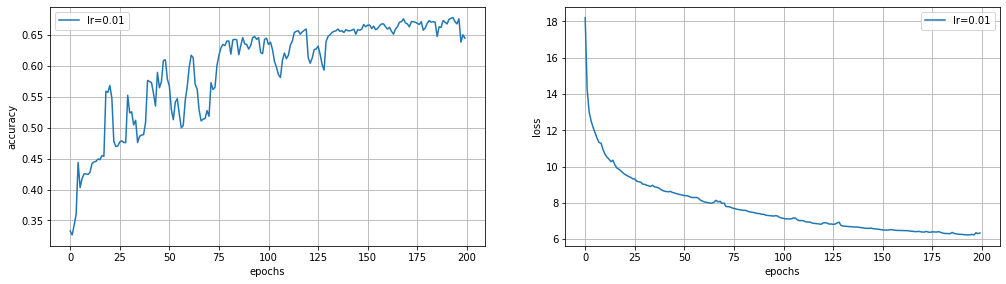

In [ ]:
# passing dictionary but running with both users no partial
from IPython.core.pylabtools import figsize
# results with range(args.num_users)
import matplotlib.pyplot as plt
figures, axes = plt.subplots(nrows=1,ncols=2,figsize = (15,5))
figures.tight_layout(pad = 5)
axes[0].plot(train_accuracy,label='lr='+str(args.lr))
axes[0].set_xlabel('epochs')
axes[0].set_ylabel('accuracy')
axes[0].legend()
axes[0].grid()
axes[1].plot(train_loss,label='lr='+str(args.lr))
axes[1].set_xlabel('epochs')
axes[1].set_ylabel('loss')
axes[1].legend()
axes[1].grid()
filename = 'synthetic_1_1'+args.optimizer+'_'+str(args.partial_users)+'of'+str(args.num_users)
figures.savefig(filename)

In [ ]:
#save the output file as csv
import csv
with open(filename+'.csv', 'w') as f: 
    write = csv.writer(f) 
    write.writerow(train_accuracy) 
    write.writerow(train_loss)